note to self:
use this to activate environment

`source /usr/local/Caskroom/miniconda/base/etc/profile.d/conda.sh`

`conda activate benchmark-datasets`

In [1]:
import networkx as nx
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import time
import altair as alt

# Enron email dataset

In [2]:
foldernames = os.listdir("data/maildir")

In [3]:
def read_email_folder(name):
    basepath = "data/maildir/" + name
    evaluated_files = []

    graph = nx.Graph()

    for dir in os.listdir(basepath):
        if (dir == ".DS_Store"): continue
        newpath = basepath + "/" + dir

        for email in os.listdir(newpath):
            f = open(newpath + "/" + email, "r")

            from_name = ""
            to_name = ""
            year = ""
            month = ""

            message_already_evaluated = False

            for text in f.readlines():

                if "Message-ID:" == text.split(" ")[0]:
                    if text.split(" ")[1] in evaluated_files:
                        message_already_evaluated = True
                    else: 
                        evaluated_files.append(text.split(" ")[1])
                if "X-From:" == text.split(" ")[0]:
                    from_name = text.replace("X-From:", "").strip()
                if "X-To:" == text.split(" ")[0]:
                    to_name = text.replace("X-To:", "").strip()
                if "Date:" == text.split(" ")[0]:
                    try: 
                        datetime_object = datetime.strptime(text.replace("Date:", "")[5:17].strip(), "%d %b %Y")
                        year = datetime_object.year
                        month = datetime_object.month
                    except: pass

            if not message_already_evaluated:
                graph.add_node(from_name)
                graph.add_node(to_name)
                graph.add_edge(from_name, to_name)

                if from_name != "" and to_name != "" and from_name != to_name:
                    graph.add_edge(from_name, to_name)

    return graph

graph = read_email_folder("arnold-j")

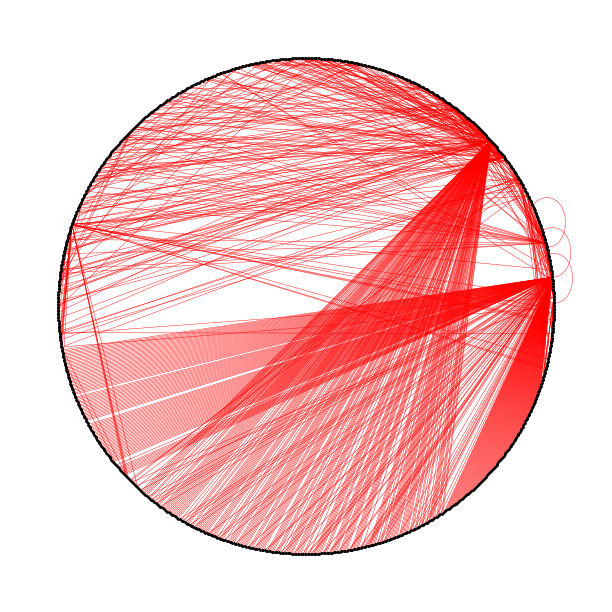

In [4]:
pos = nx.circular_layout(graph)
fig = plt.figure(1, figsize=(10, 10), dpi=60)
nx.draw(graph, pos, with_labels=False, node_size=5, width=0.5, node_color='black', edge_color='red')

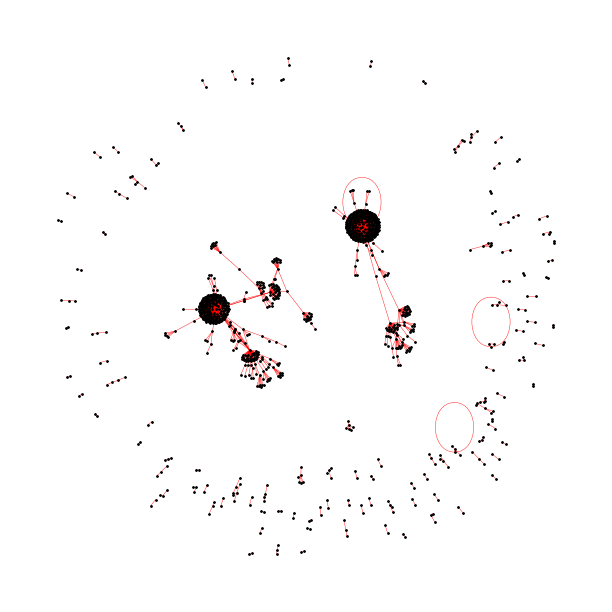

In [5]:
fig = plt.figure(1, figsize=(10, 10), dpi=60)
nx.draw(graph, pos=nx.spring_layout(graph), with_labels=False, node_size=5, width=0.5, node_color='black', edge_color='red')

In [6]:
def plot_degrees(graph):
    degdict = {}
    for deg in graph.degree():
        if deg[1] not in degdict:
            degdict[deg[1]] = 1
        else: degdict[deg[1]] += 1

    print(list(degdict.keys()))
    print(list(degdict.values()))

    source = pd.DataFrame({
        'a': list(degdict.keys()),
        'b': list(degdict.values())
    })

    return alt.Chart(source).mark_bar().encode(
        x='a',
        y='b'
    )

plot_degrees(graph)

[1, 2, 3, 23, 4, 284, 7, 33, 5, 13, 9, 54, 6, 224, 8, 16, 26]
[955, 66, 25, 1, 6, 1, 3, 1, 8, 3, 2, 1, 1, 1, 1, 1, 1]


alt.Chart(...)

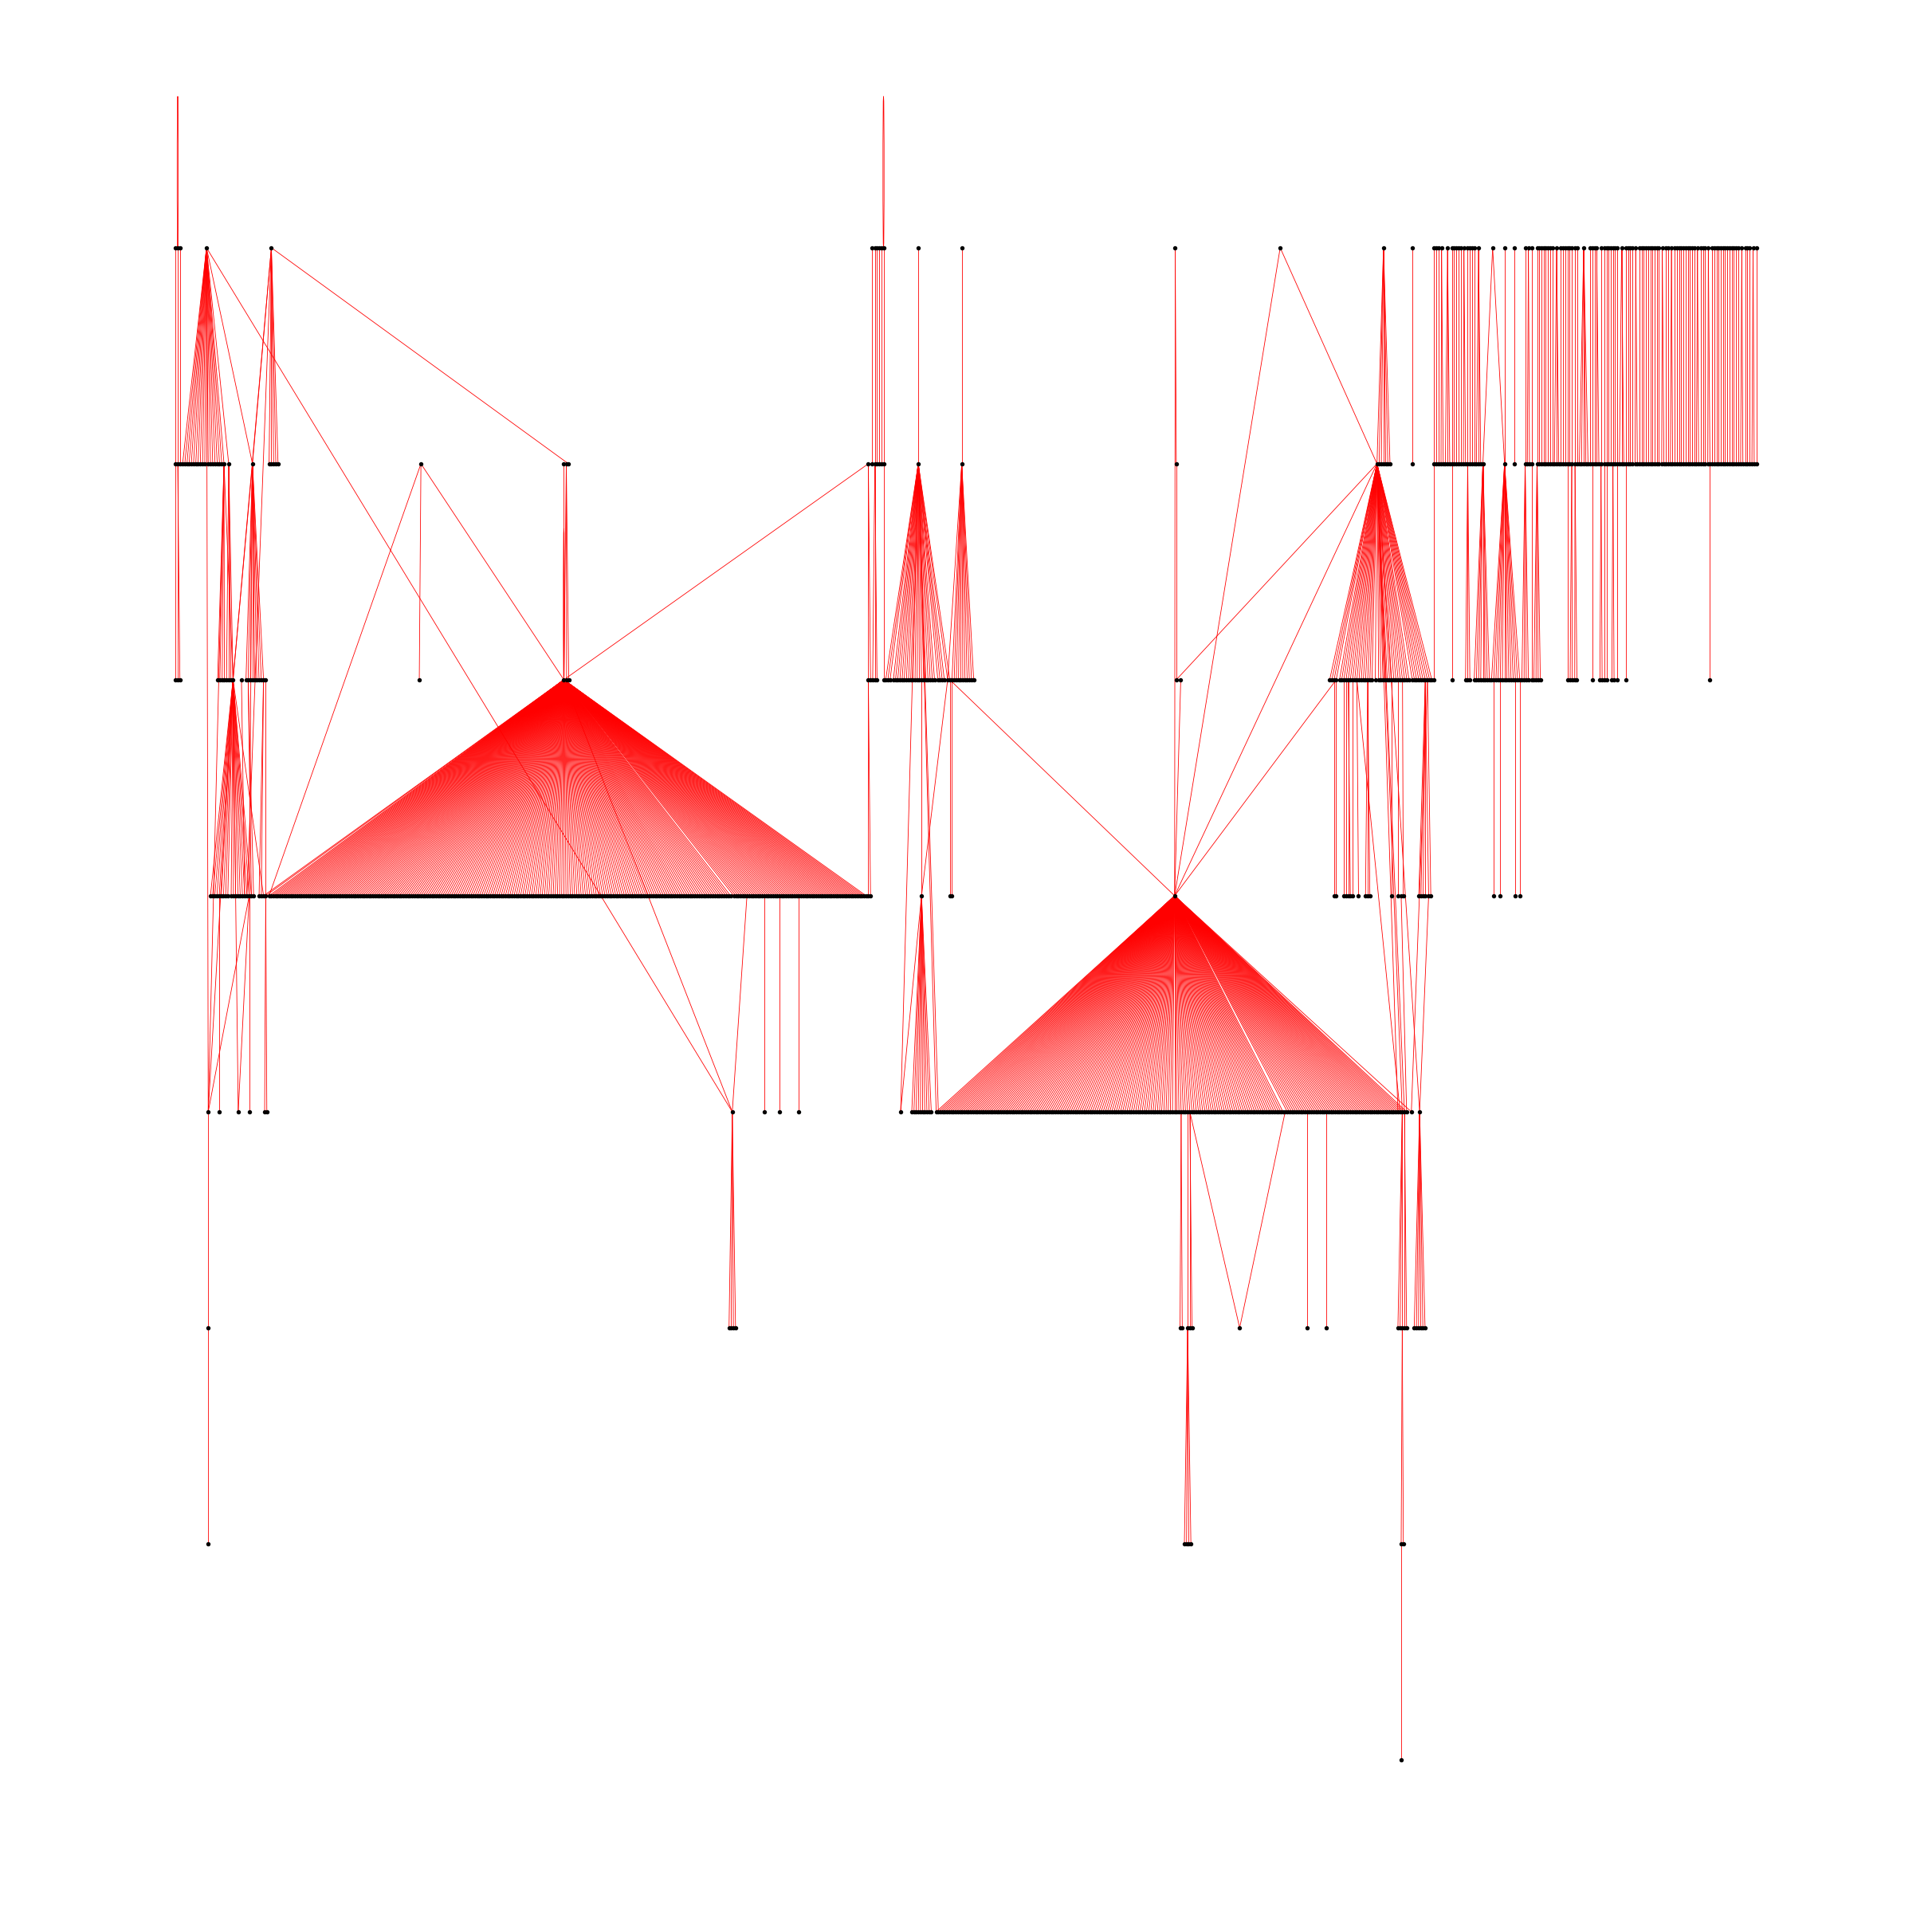

In [7]:
def process_with_graphviz(graph):
    H = nx.convert_node_labels_to_integers(graph, label_attribute="node_label")
    return (nx.nx_agraph.pygraphviz_layout(H, prog="dot"), H)

def draw_graph(graph, layout):
    fig = plt.figure(1, figsize=(20, 20), dpi=120)
    nx.draw(graph, pos=layout, with_labels=False, node_size=5, width=0.5, node_color='black', edge_color='red')

layout, converted_graph = process_with_graphviz(graph)
draw_graph(converted_graph, layout)


In [14]:
# merge multiple graphs together
largegraph = nx.Graph()

count = 0
for folder in foldernames:
    try: 
        graph = read_email_folder(folder)
        largegraph = nx.compose(largegraph, graph)
    except:
        pass
    count += 1
    if count >= 2: break

layout, converted_graph = process_with_graphviz(largegraph)
# draw_graph(converted_graph, layout)


In [15]:
resultdict = {}

count = 0
for folder in foldernames:
    count += 1
    if count >= 200: break
    
    resultdict[folder] = {}
    start = time.time()
    try: 
        graph = read_email_folder(folder)
        layout, converted_graph = process_with_graphviz(graph)
        resultdict[folder]["nodes"] = graph.number_of_nodes()
        resultdict[folder]["edges"] = graph.number_of_edges()
        resultdict[folder]["time"] = time.time() - start
    except:
        pass

print(resultdict)

{'arnold-j': {'nodes': 1077, 'edges': 989, 'time': 1.6271748542785645}, 'phanis-s': {'nodes': 43, 'edges': 32, 'time': 0.1911168098449707}, 'lavorato-j': {}, 'stclair-c': {'nodes': 556, 'edges': 540, 'time': 2.0127508640289307}, 'townsend-j': {'nodes': 344, 'edges': 285, 'time': 0.6461398601531982}, 'forney-j': {'nodes': 430, 'edges': 392, 'time': 0.6455910205841064}, 'symes-k': {}, 'reitmeyer-j': {'nodes': 364, 'edges': 324, 'time': 0.48565196990966797}, 'hyatt-k': {}, 'steffes-j': {}, 'kaminski-v': {}, 'wolfe-j': {}, 'mcconnell-m': {}, 'skilling-j': {}, 'zipper-a': {'nodes': 809, 'edges': 735, 'time': 1.3257451057434082}, 'shively-h': {}, 'donoho-l': {}, 'sanchez-m': {}, 'delainey-d': {'nodes': 527, 'edges': 520, 'time': 2.8711748123168945}, 'germany-c': {}, 'whalley-l': {'nodes': 734, 'edges': 657, 'time': 2.3298356533050537}, 'buy-r': {}, 'harris-s': {'nodes': 570, 'edges': 424, 'time': 0.5203652381896973}, 'tholt-j': {'nodes': 629, 'edges': 555, 'time': 1.1944260597229004}, 'cash-

In [16]:
times = []
node_nums = []
edge_nums = []

for entry in resultdict:
    if resultdict[entry] == {}: continue
    times.append(resultdict[entry]["time"])
    node_nums.append(resultdict[entry]["nodes"])
    edge_nums.append(resultdict[entry]["edges"])

source = pd.DataFrame({
    'time': times,
    'number of nodes': node_nums
})

alt.Chart(source).mark_circle(size=60).encode(
    x='time',
    y='number of nodes'
)

alt.Chart(...)

In [17]:
source = pd.DataFrame({
    'time': times,
    'number of edges': edge_nums
})

alt.Chart(source).mark_circle(size=60).encode(
    x='time',
    y='number of edges'
)

alt.Chart(...)

## layered enron

In [4]:
import MultiLayerNetworkDraw

In [5]:
def read_all_years_in_dataset():
    years = []
    for i, folder in enumerate(foldernames):
        if i == 2: break
        if (folder == ".DS_Store"): continue
        basepath = "data/maildir/" + folder

        try: 
            for dir in os.listdir(basepath):
                if (dir == ".DS_Store"): continue
                newpath = basepath + "/" + dir

                for email in os.listdir(newpath):
                    try: 
                        f = open(newpath + "/" + email, "r")
                        for text in f.readlines():
                            if "Date:" == text.split(" ")[0]:
                                datetime_object = datetime.strptime(text.replace("Date:", "")[5:17].strip(), "%d %b %Y")
                                year = datetime_object.year
                                if year not in years: years.append(year)
                    except: pass
        except: pass
            
    filter(lambda x: x > 1000, years)
    return years

def read_email_folder_by_year(name, yr):
    basepath = "data/maildir/" + name
    evaluated_files = []

    graph = nx.Graph()

    for dir in os.listdir(basepath):
        if (dir == ".DS_Store"): continue
        newpath = basepath + "/" + dir

        for email in os.listdir(newpath):
            f = open(newpath + "/" + email, "r")

            from_name = ""
            to_name = ""
            year = ""
            month = ""

            message_already_evaluated = False
            wrong_year = False

            for text in f.readlines():

                if "Message-ID:" == text.split(" ")[0]:
                    if text.split(" ")[1] in evaluated_files:
                        message_already_evaluated = True
                    else: 
                        evaluated_files.append(text.split(" ")[1])
                if "X-From:" == text.split(" ")[0]:
                    from_name = text.replace("X-From:", "").strip()
                if "X-To:" == text.split(" ")[0]:
                    to_name = text.replace("X-To:", "").strip()
                if "Date:" == text.split(" ")[0]:
                    try: 
                        datetime_object = datetime.strptime(text.replace("Date:", "")[5:17].strip(), "%d %b %Y")
                        year = datetime_object.year
                        month = datetime_object.month
                        if year != yr: wrong_year = True
                    except: pass

            if not message_already_evaluated and not wrong_year:
                graph.add_node(from_name)
                graph.add_node(to_name)
                graph.add_edge(from_name, to_name)

                if from_name != "" and to_name != "" and from_name != to_name:
                    graph.add_edge(from_name, to_name)

    return graph

print(read_all_years_in_dataset())

[2000, 2001, 2002, 1979]


In [6]:
graph = read_email_folder_by_year("arnold-j", 2000)

betweenness = nx.betweenness_centrality(graph)
for el in betweenness:
    if betweenness[el] > 0: print(el, betweenness[el])

John.Arnold@enron.com 2.541942043721403e-05
Jeff Youngflesh 0.1059735638027453
Caroline Abramo 0.011362480935434672
Karen Arnold <klarnold@flash.net> 0.016980172852058974
john.arnold@enron.com 0.005693950177935943
Jennifer Fraser 0.005693950177935943
John Arnold 0.5658617183528215
jarnold@enron.com 2.541942043721403e-05
Ina Rangel 0.005693950177935943
Enron Announcements 7.625826131164208e-05
Kim Godfrey 0.04439078122352143
Craig H Brown 0.03877308930689713
Colleen Koenig 0.03404084053550244
Jennifer Medcalf 0.08827741060837141
Sarah-Joy Hunter 0.32390696492119964
Matt Harris 0.006376037959667853
Jennifer Stewart 0.033824775461786104
Gary Waxman 0.005693950177935943
Sarah-joy Hunter 0.005935434672089474
Jeffrey A Shankman 0.2878495170310117
John Will 0.004520420267751229
Derryl Cleaveland 0.005693950177935943
"Jordan, Bob" <Bob.Jordan@COMPAQ.com> 2.541942043721403e-05
"O'Brien, Sean" <Sean.O'Brien@am.sony.com> 2.541942043721403e-05
Trey Comiskey 0.011362480935434672
Fernley Dyson 0.005

In [7]:
def filter_nodes_by_betweenness_centrality(graph):
    print(len(graph.nodes()))
    betweenness = nx.betweenness_centrality(graph)
    for el in betweenness:
        if betweenness[el] == 0: graph.remove_node(el)
    print(len(graph.nodes()))

In [8]:
graph = read_email_folder_by_year("arnold-j", 2000)
filter_nodes_by_betweenness_centrality(graph)
graph2 = read_email_folder_by_year("arnold-j", 2001)
filter_nodes_by_betweenness_centrality(graph2)
graph3 = read_email_folder_by_year("arnold-j", 2001)
filter_nodes_by_betweenness_centrality(graph3)

282
26
841
89
841
89


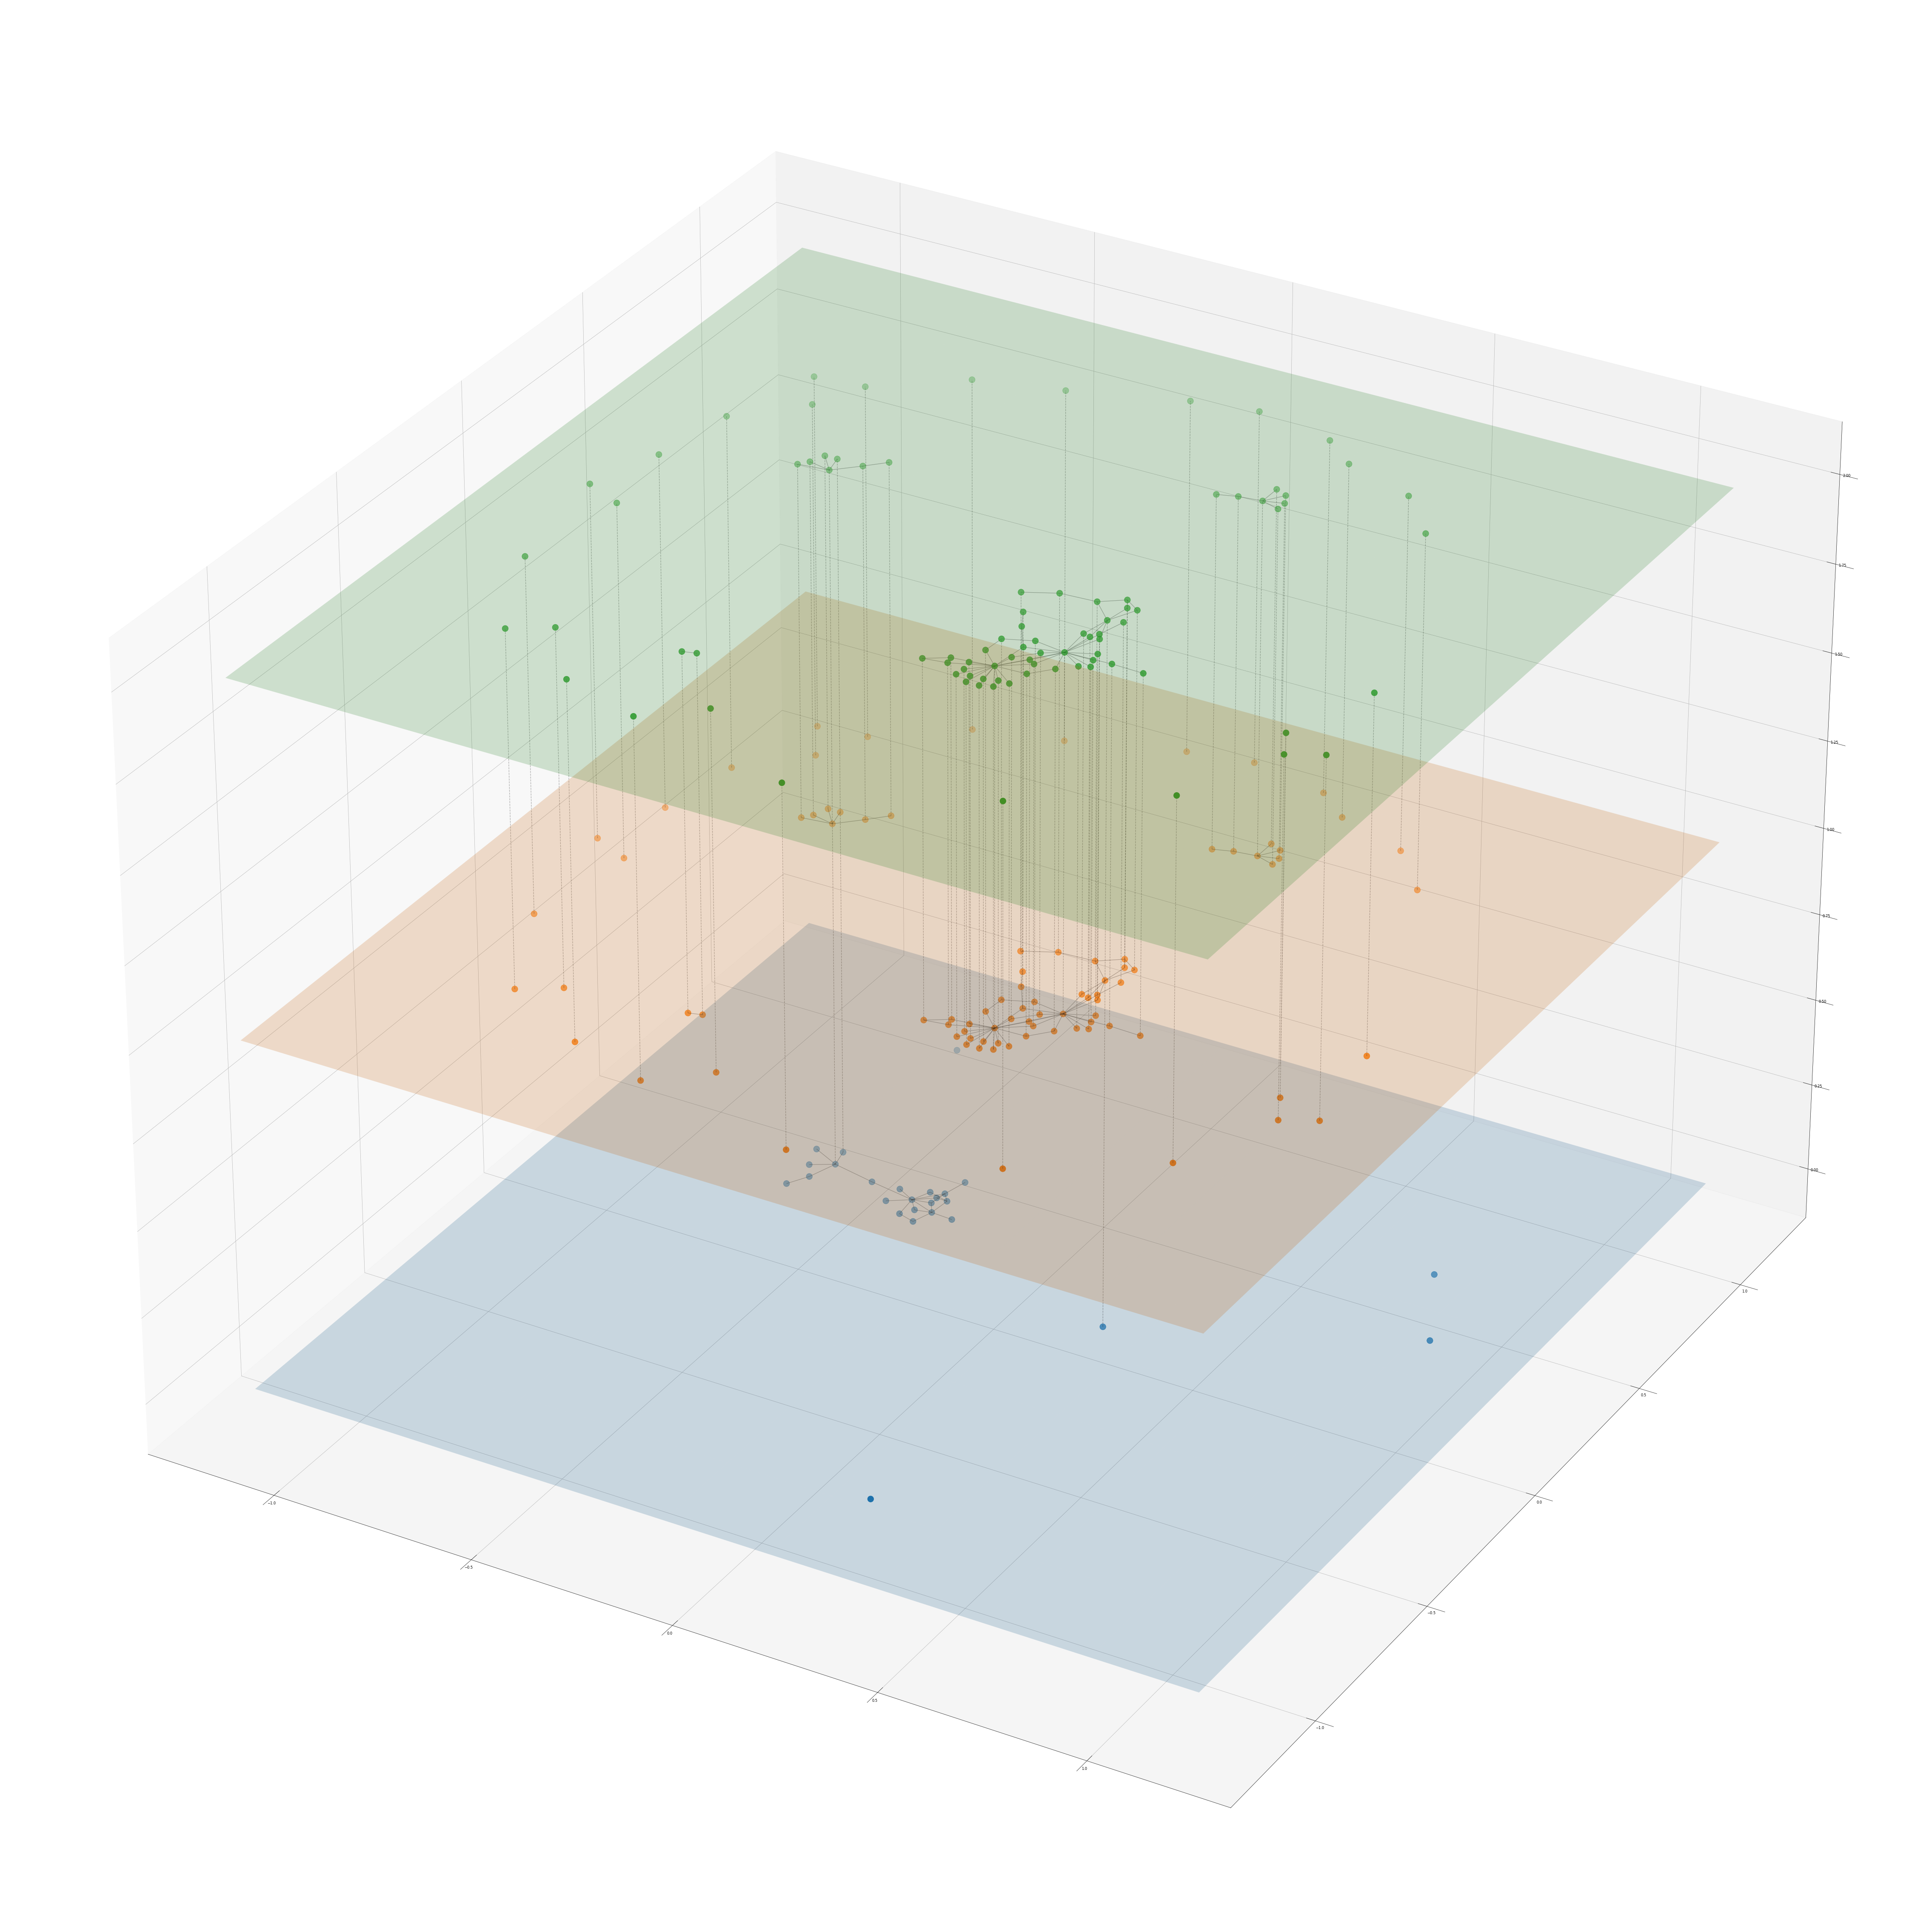

In [9]:
# fig = plt.figure(1, figsize=(100, 100), dpi=60)
layered_network = MultiLayerNetworkDraw.LayeredNetworkGraph([graph, graph2, graph3])
# layered_network.draw()


